### 4th European Conference On Social Networks
## Workshop: Introduction to Python's Graph-Tool
# 2. Bipartite Graphs
**Authors**: <a href='https://www.gesis.org/person/haiko.lietz'>Haiko Lietz</a>, <a href='https://www.gesis.org/person/marcos.oliveira'>Marcos Oliveira</a>, GESIS - Leibniz Institute for the Social Sciences

**Version Date**: 12 September 2019

**Description**: This notebook introduces ...

**License**: <a href='https://www.gnu.org/licenses/gpl-3.0.en.html'>GNU General Public License 3.0</a>
***
<img src = 'images/bipartite.png'>

## 2.1. Toy Example

In [1]:
import pandas as pd

In [2]:
selections = [['a_1', 'f_1'], ['a_1', 'f_2'], ['a_1', 'f_3'], ['a_1', 'f_4'], ['a_1', 'f_5'], ['a_2', 'f_3'], ['a_2', 'f_4'], ['a_2', 'f_5'], ['a_2', 'f_6'], ['a_3', 'f_5'], ['a_3', 'f_6'], ['a_3', 'f_7'], ['a_4', 'f_7'], ['a_4', 'f_8'], ['a_5', 'f_9']]
selections = pd.DataFrame(selections, columns=['transaction', 'fact'])
selections['weight'] = 1
selections.head()

,transaction,fact,weight
0,a_1,f_1,1
1,a_1,f_2,1
2,a_1,f_3,1
3,a_1,f_4,1
4,a_1,f_5,1


### 2.1.1. Matrix Projection

In [3]:
def project_bipartite(df_selections, projection, norm=True, remove_diagonal=False, sym=False):
    # dependencies
    import itertools
    import numpy as np
    import pandas as pd
    from scipy.sparse import csr_matrix, coo_matrix, triu
    from sklearn.preprocessing import normalize
    # function
    if {'transaction', 'fact', 'weight'}.issubset(df_selections.columns):
        def extract_vertices(df, *columns):
            l = [df[column].unique().tolist() for column in columns]
            return list(set(itertools.chain.from_iterable(l)))
        transactions = extract_vertices(df_selections, 'transaction')
        transactions_id = {value: i for i, value in enumerate(transactions)}
        facts = extract_vertices(df_selections, 'fact')
        facts_id = {value: i for i, value in enumerate(facts)}
        rows = [transactions_id[x] for x in df_selections['transaction'].values]
        columns = [facts_id[y] for y in df_selections['fact'].values]
        cells = df_selections['weight'].tolist()
        G = coo_matrix((cells, (rows, columns))).tocsr()
        if projection == 'transactions':
            if norm == False:
                GT = csr_matrix.transpose(G)
                I = G*GT
            else:
                GN = normalize(G, norm='l1', axis=1)
                GNT = csr_matrix.transpose(GN)
                I = GN*GNT
            transactions = pd.DataFrame(transactions)
            transactions.columns = ['transaction']
            if remove_diagonal == True:
                I = I.tolil()
                I.setdiag(0)
            if sym == False:
                return I.tocsr(), transactions
            else:
                return triu(I.tocoo()).tocsr(), transactions
        if projection == 'facts':
            GT = csr_matrix.transpose(G)
            if norm == False:
                H = GT*G
            else:
                GN = normalize(G, norm='l1', axis=1)
                H = GT*GN
            w = pd.Series(np.squeeze(np.array(H.sum(axis=1))))
            d = pd.Series(np.array(H.diagonal()))
            e = d/w
            H_nodiag = H.tolil()
            H_nodiag.setdiag(values=0)
            k = pd.Series(np.array([len(i) for i in H_nodiag.data.tolist()]))
            s = k/w
            facts = pd.Series(facts)
            facts = pd.concat([facts, k, w, d, e, s], axis=1)
            facts.columns = ['fact', 'degree', 'weight', 'self_selection', 'embeddedness', 'sociability']
            if remove_diagonal == True:
                H = H.tolil()
                H.setdiag(0)
            if sym == False:
                return H.tocsr(), facts
            else:
                return triu(H.tocoo()).tocsr(), facts
    else:
        print('Dataframe is not a proper selection table.')

In [4]:
I, transactions = project_bipartite(df_selections=selections, projection='transactions', norm=False, remove_diagonal=True, sym=True)

In [5]:
I_norm, _ = project_bipartite(df_selections=selections, projection='transactions', norm=True, remove_diagonal=True, sym=True)

In [6]:
transactions

,transaction
0,a_4
1,a_3
2,a_2
3,a_5
4,a_1


In [7]:
print(I)

  (0, 1)	1
  (1, 2)	2
  (1, 4)	1
  (2, 4)	3


In [8]:
print(I_norm)

  (0, 1)	0.16666666666666666
  (1, 2)	0.16666666666666666
  (1, 4)	0.06666666666666667
  (2, 4)	0.15000000000000002


In [9]:
H, facts = project_bipartite(df_selections=selections, projection='facts', norm=False, remove_diagonal=True, sym=True)

In [10]:
H_norm, facts_norm = project_bipartite(df_selections=selections, projection='facts', norm=True, remove_diagonal=True, sym=True)

In [11]:
facts

,fact,degree,weight,self_selection,embeddedness,sociability
0,f_6,4,7,2,0.285714,0.571429
1,f_9,0,1,1,1.000000,0.000000
2,f_5,6,12,3,0.250000,0.500000
3,f_1,4,5,1,0.200000,0.800000
4,f_2,4,5,1,0.200000,0.800000
5,f_8,1,2,1,0.500000,0.500000
6,f_7,3,5,2,0.400000,0.600000
7,f_3,5,9,2,0.222222,0.555556
8,f_4,5,9,2,0.222222,0.555556


In [12]:
facts_norm

,fact,degree,weight,self_selection,embeddedness,sociability
0,f_6,4,2.0,0.583333,0.291667,2.0
1,f_9,0,1.0,1.000000,1.000000,0.0
2,f_5,6,3.0,0.783333,0.261111,2.0
3,f_1,4,1.0,0.200000,0.200000,4.0
4,f_2,4,1.0,0.200000,0.200000,4.0
5,f_8,1,1.0,0.500000,0.500000,1.0
6,f_7,3,2.0,0.833333,0.416667,1.5
7,f_3,5,2.0,0.450000,0.225000,2.5
8,f_4,5,2.0,0.450000,0.225000,2.5


In [13]:
print(H)

  (0, 2)	2
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (2, 3)	1
  (2, 4)	1
  (2, 6)	1
  (2, 7)	2
  (2, 8)	2
  (3, 4)	1
  (3, 7)	1
  (3, 8)	1
  (4, 7)	1
  (4, 8)	1
  (5, 6)	1
  (7, 8)	2


In [14]:
print(H_norm)

  (0, 2)	0.5833333333333333
  (0, 6)	0.3333333333333333
  (0, 7)	0.25
  (0, 8)	0.25
  (2, 3)	0.2
  (2, 4)	0.2
  (2, 6)	0.3333333333333333
  (2, 7)	0.45
  (2, 8)	0.45
  (3, 4)	0.2
  (3, 7)	0.2
  (3, 8)	0.2
  (4, 7)	0.2
  (4, 8)	0.2
  (5, 6)	0.5
  (7, 8)	0.45


### 2.1.2. Graph Construction

In [15]:
i = H_norm.nonzero()[0].tolist()
j = H_norm.nonzero()[1].tolist()
weight = H_norm.data.tolist()

In [16]:
i

[0, 0, 0, 0, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 7]

In [17]:
j

[2, 6, 7, 8, 3, 4, 6, 7, 8, 4, 7, 8, 7, 8, 6, 8]

In [18]:
weight

[0.5833333333333333,
 0.3333333333333333,
 0.25,
 0.25,
 0.2,
 0.2,
 0.3333333333333333,
 0.45,
 0.45,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.5,
 0.45]

In [19]:
import numpy as np

In [20]:
a = np.array([i, j, weight]).T

In [21]:
from graph_tool.all import *

In [22]:
openmp_set_num_threads(2)

In [23]:
facts_norm.head()

,fact,degree,weight,self_selection,embeddedness,sociability
0,f_6,4,2.0,0.583333,0.291667,2.0
1,f_9,0,1.0,1.000000,1.000000,0.0
2,f_5,6,3.0,0.783333,0.261111,2.0
3,f_1,4,1.0,0.200000,0.200000,4.0
4,f_2,4,1.0,0.200000,0.200000,4.0


In [24]:
g = Graph(directed=False)
vp_fact = g.new_vertex_property('string')
for i in range(0, len(facts_norm)):
    v = g.add_vertex()
    vp_fact[v] = facts_norm['fact'][i]
g.vertex_properties['fact'] = vp_fact
ep_weight = g.new_edge_property('double')
g.add_edge_list(a, eprops=[ep_weight])
g.edge_properties['weight'] = ep_weight

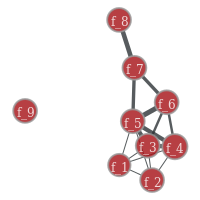

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff15434b128, at 0x7ff154346dd8>

In [25]:
graph_draw(g, vertex_text=g.vp.fact, edge_pen_width=prop_to_size(g.ep.weight, mi=1, ma=5), output_size=(200, 200))

## 2.2. Social Network Science: Bipartite Graph of Work Concept Usage

In [26]:
usages = pd.read_csv('data/sns/usages.txt', header='infer', delimiter='\t', encoding='utf-8')
usages.head()

,publication_id,word_id
0,0,0
1,0,1
2,7,2
3,8,0
4,12,3


In [27]:
publications = pd.read_csv('data/sns/publications.txt', header='infer', delimiter='\t', encoding='utf-8')
publications.head()

,publication_id,publication,time,type,domain_id
0,0,HANIFAN_1916_A_130,1916,ARTICLE,0
1,1,YULE_1925_P_21,1925,ARTICLE,1
2,2,KERMACK_1927_P_700,1927,ARTICLE,1
3,3,ECKART_1936_P_211,1936,ARTICLE,2
4,4,COASE_1937_E_386,1937,ARTICLE,1


In [28]:
words = pd.read_csv('data/sns/words.txt', header='infer', delimiter='\t', encoding='utf-8')
words.head()

,word_id,word
0,0,COMMUNITY
1,1,RURAL_SCHOOL
2,2,WAY_OF_LIFE
3,3,GROUP_STRUCTURE
4,4,THEORY_OF_COMMUNICATION


In [29]:
foo = pd.merge(left=usages, right=publications[['publication_id', 'publication']], on='publication_id')
usages = pd.merge(left=foo, right=words, on='word_id')[['publication', 'word']]
usages.columns = ['transaction', 'fact']
usages['weight'] = 1
usages.head()

,transaction,fact,weight
0,HANIFAN_1916_A_130,COMMUNITY,1
1,RYAN_1943_R_15,COMMUNITY,1
2,HILLERY_1955_R_111,COMMUNITY,1
3,LAUMANN_1973_A_212,COMMUNITY,1
4,NUTINI_1977_E_353,COMMUNITY,1


In [30]:
len(usages)

201594

### 2.2.1. Matrix Projection
#### 2.2.1.1. Publication Similarity Graph

In [31]:
I_norm, transactions_norm = project_bipartite(df_selections=usages, projection='transactions', norm=True, remove_diagonal=True, sym=True)

In [32]:
transactions_norm.head()

,transaction
0,FREZZO_2010_J_105
1,SITEK_2006_PROCEEDINGS_816
2,LAMERTZ_2006_O_79
3,SEGERSTR_2008_B_279
4,NICOLAOU_2003_J_333


In [33]:
I_norm.shape

(25186, 25186)

In [34]:
u = I_norm.nonzero()[0].tolist()
v = I_norm.nonzero()[1].tolist()
w = I_norm.data.tolist()
a = np.array([u, v, w]).T

In [35]:
i = Graph(directed=False)
i_vp_transaction = i.new_vertex_property('string')
for Iter in range(0, len(transactions_norm)):
    v = i.add_vertex()
    i_vp_transaction[v] = transactions_norm['transaction'][Iter]
i.vertex_properties['transaction'] = i_vp_transaction
i_ep_similarity = i.new_edge_property('double')
i.add_edge_list(a, eprops=[i_ep_similarity])
i.edge_properties['similarity'] = i_ep_similarity

In [36]:
i.num_vertices()

25186

In [37]:
i.num_edges()

27645318

In [38]:
# the graph has too many edges to draw
# extract the minimum spanning tree
tree = min_spanning_tree(i, weights=i.ep.similarity)

In [39]:
#get largest hub as root of the tree
k = i.get_out_degrees(vs=i.get_vertices())
max(k)

9950

In [40]:
ix = np.argmax(k)

In [41]:
i.get_out_degrees(vs=[ix])

array([9950], dtype=uint64)

In [42]:
v = i.vertex(ix)
print(i.vp.transaction[v])

FANG_2010_SIGIR_917


In [43]:
i_tree = GraphView(i, efilt=tree)

In [44]:
i_tree.num_vertices()

25186

In [45]:
i_tree.num_edges()

25159

In [46]:
i_tree_pos = radial_tree_layout(i_tree, root=ix)

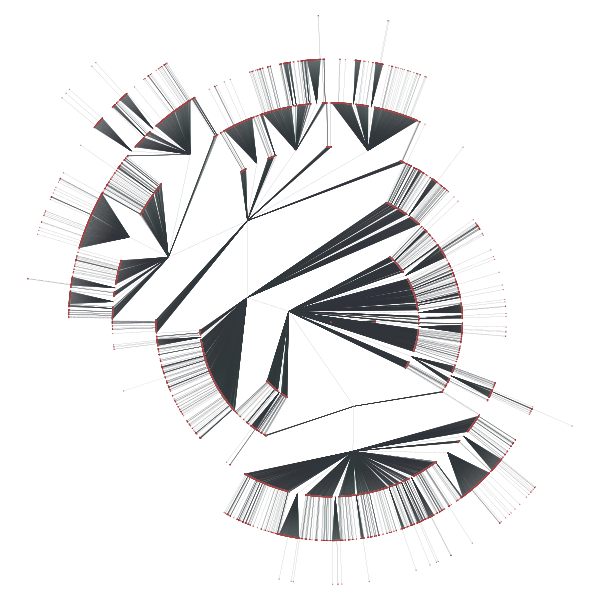

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff047820048, at 0x7ff047820cc0>

In [47]:
graph_draw(i_tree, pos=i_tree_pos)

#### 2.2.1.2. Word Co-Usage Graph

In [48]:
H_norm, facts_norm = project_bipartite(df_selections=usages, projection='facts', norm=True, remove_diagonal=True, sym=True)

In [49]:
H_norm.shape

(23025, 23025)

In [50]:
x = H_norm.nonzero()[0].tolist()
y = H_norm.nonzero()[1].tolist()
z = H_norm.data.tolist()
b = np.array([x, y, z]).T

In [51]:
h = Graph(directed=False)
h_vp_fact = h.new_vertex_property('string')
h_vp_weight = h.new_vertex_property('double')
for Iter in range(0, len(facts_norm)):
    v = h.add_vertex()
    h_vp_fact[v] = facts_norm['fact'][Iter]
    h_vp_weight[v] = facts_norm['weight'][Iter]
h.vertex_properties['fact'] = h_vp_fact
h.vertex_properties['weight'] = h_vp_weight
h_ep_weight = h.new_edge_property('double')
h.add_edge_list(b, eprops=[h_ep_weight])
h.edge_properties['weight'] = h_ep_weight

In [52]:
h.num_vertices()

23025

In [53]:
h.num_edges()

602976

In [54]:
# the graph is to large to draw: filter the core
# get edge weight histogram
Min = min(h.ep.weight.a)
Max = max(h.ep.weight.a)
counts, bins = edge_hist(h, eprop=h.ep.weight, bins=np.logspace(np.log10(Min), np.log10(Max), 20))

In [55]:
import matplotlib.pyplot as plt

Text(0,0.5,'number of edges')

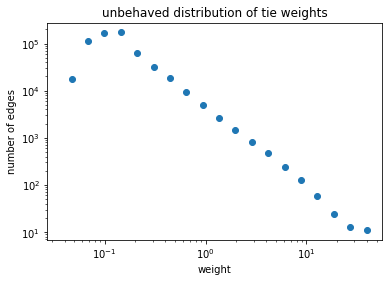

In [56]:
plt.scatter(bins[-len(counts):], counts)
plt.xscale('log')
plt.yscale('log')
plt.title('unbehaved distribution of tie weights')
plt.xlabel('weight')
plt.ylabel('number of edges')

In [57]:
# filter edges
minimum_edge_weight = 10
h_ep_core_edges = h.ep.weight.a > minimum_edge_weight

In [58]:
h_efilt = GraphView(h, efilt=h_ep_core_edges)

In [59]:
h_efilt.num_edges()

75

In [60]:
h_efilt.num_vertices()

23025

In [61]:
# the graph still has all vertices
# just extract the largest component
lcc = label_largest_component(h_efilt)

In [62]:
h_efilt_lcc = GraphView(h_efilt, vfilt=lcc)

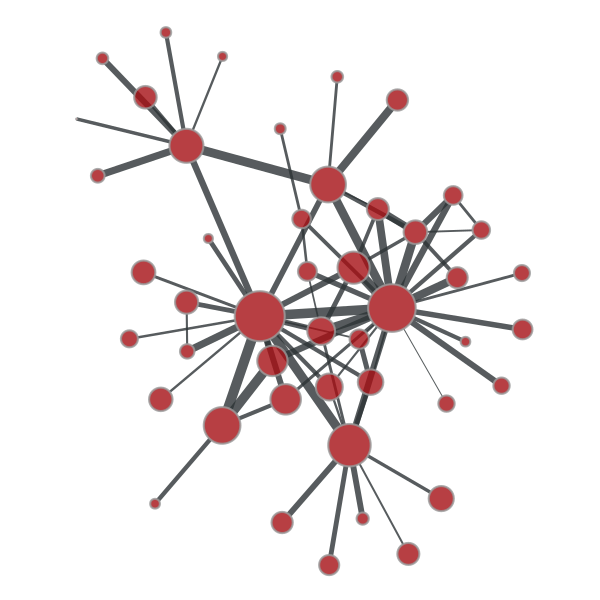

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff0751cc278, at 0x7ff0751af5c0>

In [63]:
graph_draw(h_efilt_lcc, 
           #vertex_text=h_efilt_lcc.vp.fact, 
           #vertex_text_position=0, 
           vertex_size=prop_to_size(h_efilt_lcc.vp.weight, 1, 50), 
           edge_pen_width=prop_to_size(h_efilt_lcc.ep.weight, 1, 10))

In [64]:
# or just show components with a minimum size
h_efilt_vp_component = h_efilt.new_vertex_property('int')
label_components(h_efilt, vprop=h_efilt_vp_component) # store id of component node belongs to in property map

(<PropertyMap object with key type 'Vertex' and value type 'int32_t', for Graph 0x7ff13ea61ac8, at 0x7ff0751af780>,
 array([1, 1, 1, ..., 1, 1, 1], dtype=uint64))

In [65]:
minimum_component_size = 2
c = h_efilt_vp_component.a.tolist()
core_components = list(set([x for x in c if c.count(x) >= minimum_component_size]))

In [66]:
h_efilt_vp_core_component = h_efilt.new_vertex_property('bool')
for v in h_efilt.vertices():
    h_efilt_vp_core_component[v] = h_efilt_vp_component[v] in core_components

In [67]:
h_efilt_vfilt = GraphView(h, vfilt=h_efilt_vp_core_component, efilt=h_ep_core_edges)

In [68]:
h_efilt_vfilt.num_vertices()

48

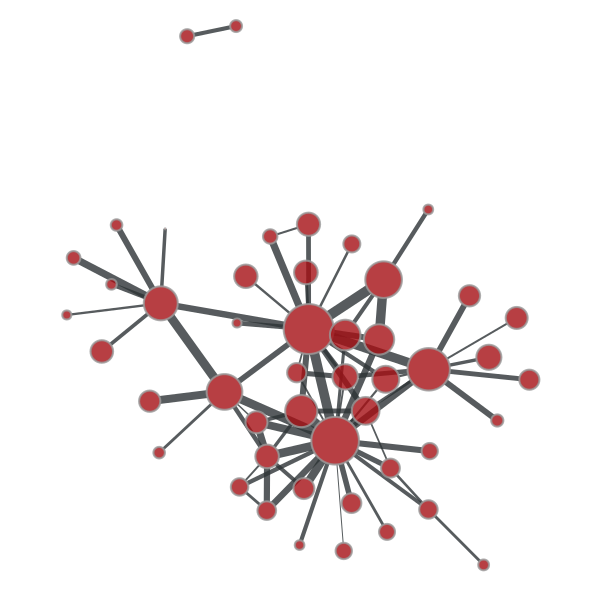

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7ff0751afef0, at 0x7ff0751b2048>

In [69]:
graph_draw(h_efilt_vfilt, 
           #vertex_text=h_efilt_vfilt.vp.fact, 
           #vertex_text_position=0, 
           vertex_size=prop_to_size(h_efilt_vfilt.vp.weight, 1, 50), 
           edge_pen_width=prop_to_size(h_efilt_vfilt.ep.weight, 1, 10))

## 2.3. Exercise
Filtering weak co-selection ties is a good way to extract the core when the tie strength distribution is very skewed - as is the case for the word co-usage network. When the tie strength distribution is not very skewed, it is better to use cohesion-based algorithms like <a href='http://intersci.ss.uci.edu/wiki/index.php/Cohesive_blocking'>k-component decomposition</a> to extract the core. The co-authorship network of Social Network Science is such a "well-behaved" graph:

In [159]:
authorships = pd.read_csv('data/sns/authorships.txt', header='infer', delimiter='\t', encoding='utf-8')
# remove papers with exceptionally many authors
foo = authorships.groupby('publication_id').size().reset_index(name='num_authors')
foo = foo[foo['num_authors'] < (np.mean(foo['num_authors'])+3*np.std(foo['num_authors']))]['publication_id']
authorships = pd.merge(left=authorships, right=foo, on='publication_id')
authorships.head()

,publication_id,author_id
0,0,0
1,1,1
2,2,2
3,2,3
4,3,4


In [160]:
publications.head()

,publication_id,publication,time,type,domain_id
0,0,HANIFAN_1916_A_130,1916,ARTICLE,0
1,1,YULE_1925_P_21,1925,ARTICLE,1
2,2,KERMACK_1927_P_700,1927,ARTICLE,1
3,3,ECKART_1936_P_211,1936,ARTICLE,2
4,4,COASE_1937_E_386,1937,ARTICLE,1


In [161]:
authors = pd.read_csv('data/sns/authors.txt', header='infer', delimiter='\t', encoding='utf-8')
authors.head()

,author_id,author
0,0,"HANIFAN,_L_J"
1,1,"YULE,_G_U"
2,2,"KERMACK,_W_O"
3,3,"MCKENDRICK,_A_G"
4,4,"ECKART,_CARL"


In [162]:
foo = pd.merge(left=authorships, right=publications[['publication_id', 'publication']], on='publication_id')
authorships = pd.merge(left=foo, right=authors, on='author_id')[['publication', 'author']]
authorships.columns = ['transaction', 'fact']
authorships['weight'] = 1
authorships.head()

,transaction,fact,weight
0,HANIFAN_1916_A_130,"HANIFAN,_L_J",1
1,YULE_1925_P_21,"YULE,_G_U",1
2,KERMACK_1927_P_700,"KERMACK,_W_O",1
3,KERMACK_1927_P_700,"MCKENDRICK,_A_G",1
4,ECKART_1936_P_211,"ECKART,_CARL",1


k-component decomposition is not available in graph-tool, but an approximation is: Every k-component is also a k-core but not vice versa. Use <a href=''>kcore_decomposition</a> to extract the core of the co-authorship network of authors that are connected if they write papers together.

In [163]:
A, authors = project_bipartite(df_selections=authorships, projection='facts', norm=False, remove_diagonal=True, sym=True)

In [205]:
i = A.nonzero()[0].tolist()
j = A.nonzero()[1].tolist()
weight = A.data.tolist()
d = np.array([i, j, weight]).T

a = Graph(directed=False)
a_vp_fact = a.new_vertex_property('string')
a_vp_degree = a.new_vertex_property('int')
for Iter in range(0, len(authors)):
    v = a.add_vertex()
    a_vp_fact[v] = authors['fact'][Iter]
    a_vp_degree[v] = authors['degree'][Iter]
a.vertex_properties['fact'] = a_vp_fact
a.vertex_properties['degree'] = a_vp_degree
a_ep_weight = a.new_edge_property('int') # 'int' because graph is not normalized
a.add_edge_list(d, eprops=[a_ep_weight])
a.edge_properties['weight'] = a_ep_weight

In [206]:
kcore = kcore_decomposition(a)

In [207]:
a_kcore = GraphView(a, vfilt=kcore.a > 5)

In [208]:
a_kcore.num_vertices(), a_kcore.num_edges()

(3407, 11652)

In [ ]:
graph_draw(a_kcore)